## Transfer Learning mobilenetV2 using Tensorflow

Please download the dataset from the below url

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = (224, 224)

train_path = '/content/drive/MyDrive/Colon Cancer/train'
valid_path = '/content/drive/MyDrive/Colon Cancer/val'
test_path = '/content/drive/MyDrive/Colon Cancer/test'

In [5]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Colon Cancer/train/*')
folders

['/content/drive/MyDrive/Colon Cancer/train/Colon Benign',
 '/content/drive/MyDrive/Colon Cancer/train/Colon Adenocarcinoma']

In [6]:
import os
Benign_train = len(os.listdir(folders[0]))
Adenocarcinoma_train = len(os.listdir(folders[1]))
print(f"No of Benign files {Benign_train}\nNo of Adenocarcinoma files {Adenocarcinoma_train}\n")

No of Benign files 3500
No of Adenocarcinoma files 3500



In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

train_datagen = ImageDataGenerator(rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 7000 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle = True)

Found 2000 images belonging to 2 classes.


In [9]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle = False)

Found 1000 images belonging to 2 classes.


### Model

In [10]:
engine = tf.keras.applications.MobileNetV2(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,
        # Use Imagenet weights
        weights = 'imagenet',
        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),
    )

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x = tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
prediction = Dense(1, activation = 'sigmoid', name = 'dense_output')(x)
 # Build the Keras model
model = Model(inputs = engine.input, outputs = prediction)

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  # optimizer='adam',
  optimizer= Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
)

Epoch 1/20
219/219 [==============================] - 1809s 8s/step - loss: 0.0550 - accuracy: 0.9786 - val_loss: 8.8280 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - 967s 4s/step - loss: 0.0270 - accuracy: 0.9914 - val_loss: 7.1346 - val_accuracy: 0.5530 - lr: 0.0010
Epoch 3/20
219/219 [==============================] - 960s 4s/step - loss: 0.0231 - accuracy: 0.9921 - val_loss: 0.2745 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 4/20
219/219 [==============================] - 938s 4s/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 1.5656 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 5/20
219/219 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9963
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
219/219 [==============================] - 969s 4s/step - loss: 0.0104 - accuracy: 0.9963 - val_loss: 7.5088 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 6/20
219/219 [==============================] - 945s

In [16]:
import matplotlib.pyplot as plt

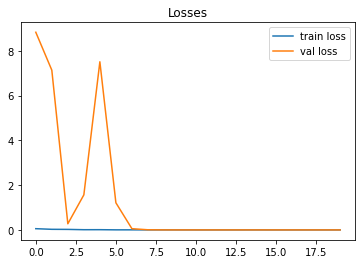

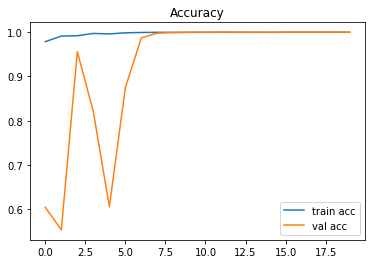

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')
plt.show()
plt.savefig('LossVal_loss')
print()
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [18]:
# average training accuracy
np.mean(r.history['accuracy'])

0.9976142853498459

In [19]:
# val accuracy
model.evaluate(val_set)

63/63 [==============================] - 80s 1s/step - loss: 4.4874e-05 - accuracy: 1.0000


[4.48735045210924e-05, 1.0]

In [20]:
# test accuracy
model.evaluate(test_set)

32/32 [==============================] - 271s 9s/step - loss: 6.9787e-05 - accuracy: 1.0000


[6.9787485699635e-05, 1.0]

In [34]:
test_set.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [21]:
test_set.class_indices

{'Colon Adenocarcinoma': 0, 'Colon Benign': 1}

In [37]:
test_set.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
prob = model.predict(test_set)
result = []
for i in range(0,len(prob)):
  if prob[i]>0.5:
    result.append(1)
  else:
    result.append(0)

print(result)

32/32 [==============================] - 28s 828ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [40]:
print('\n')
print(classification_report(test_set.labels, result,target_names = ['Colon Adenocarcinoma','Colon Benign'], digits=5))



                      precision    recall  f1-score   support

Colon Adenocarcinoma    1.00000   1.00000   1.00000       500
        Colon Benign    1.00000   1.00000   1.00000       500

            accuracy                        1.00000      1000
           macro avg    1.00000   1.00000   1.00000      1000
        weighted avg    1.00000   1.00000   1.00000      1000



In [41]:

y_true = test_set.labels
y_pred = result
cm=confusion_matrix(y_true,y_pred)
cm

array([[500,   0],
       [  0, 500]])

Text(69.0, 0.5, 'Predicted Values')

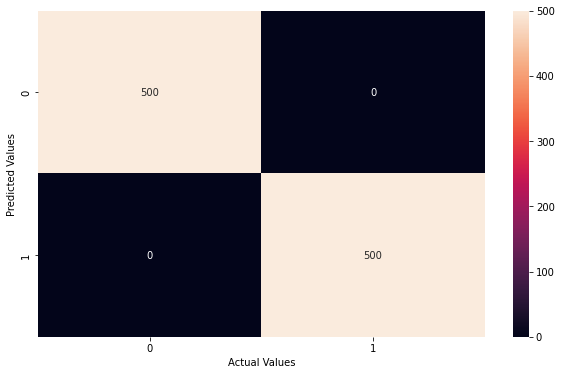

In [42]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [43]:
from sklearn.metrics import accuracy_score, f1_score,matthews_corrcoef,make_scorer, precision_score, recall_score, balanced_accuracy_score
score=accuracy_score(y_true,y_pred)
# scorers = {
#             'f1_score': make_scorer(f1_score, average='micro'),
#             # 'precision_score': make_scorer(precision_score, average='micro'),
#             # 'recall_score': make_scorer(recall_score, average='micro'),
#             'accuracy_score': make_scorer(accuracy_score)
# }
f1 = f1_score(y_true, y_pred,  average='micro')
pre = precision_score(y_true, y_pred,  average='micro')
recall = recall_score(y_true, y_pred,  average='micro')
acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true,y_pred)
# print(f"accuracy {score} f1 {f1} mcc {mcc}")

print(f1, pre, recall, acc,mcc)

1.0 1.0 1.0 1.0 1.0


In [27]:
# # save it as a h5 file
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('Transfer_Learning_colon_mobilenetV2.h5')

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('/content/Transfer_Learning_colon_mobilenetV2.h5')

In [30]:
img=image.load_img('/content/drive/MyDrive/Colon Cancer/test/Colon Benign/colonn1000.jpeg',target_size=(224,224))
x=image.img_to_array(img)
x=x/255
x.shape

(224, 224, 3)

In [44]:
# # from keras.applications.xception import preprocess_input
# import numpy as np
# x=np.expand_dims(x,axis=0)
# img_data=preprocess_input(x)
# img_data.shape

In [31]:
img_data = x.reshape(1,224,224,3)

In [32]:
result = model.predict(img_data)
# result = np.argmax(result, axis=-1)
result

1/1 [==============================] - 1s 802ms/step


array([[0.99997956]], dtype=float32)